In [2]:
import torch

import json
from types import SimpleNamespace

from Model.encoder import Embeddings, PretrainModel
from Model.decoder import LinearDecoder
import Data.Solardataloader_subset as Solardataloader_subset

加载模型

In [2]:
pretrain_json_path = './configs/pretrain/args1.json'

with open(pretrain_json_path, 'r') as f:
    pretrain_args = json.load(f)
    pretrain_args = SimpleNamespace(**pretrain_args)
for arg in vars(pretrain_args):
    print(arg, getattr(pretrain_args, arg))

checkpoint_path = f'/mnt/nas/home/huxing/202407/ctf/SolarCLIP/checkpoints/pretrain_v2/{pretrain_args.modal}/{pretrain_args.enhance_list[0]}/'
logger_checkpoint_path = checkpoint_path + 'logger/'
model_checkpoint_path = checkpoint_path + 'model/'

load_dir = model_checkpoint_path + 'epoch_3.pt'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


encoder = Embeddings(
        in_channels=1,
        input_resolution=1024,
        patch_size=64,
        width=768,
        hidden_dropout_prob=1e-1
    )
decoder = LinearDecoder(
    embed_dim=768,
    out_dim=1024*4
)
pretrainModel = PretrainModel(encoder, decoder).to(device)
pretrainModel.load_state_dict(torch.load(load_dir)['model'])
pretrainModel.to(device)

modal magnet
enhance_list ['None', 1]
epochs 11
test_freq 3


PretrainModel(
  (encoder): Embeddings(
    (conv1): Conv2d(1, 768, kernel_size=(64, 64), stride=(64, 64), bias=False)
    (ln_pre): patch_norm(
      (norm): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (decoder): LinearDecoder(
    (decoder): Sequential(
      (0): Linear(in_features=768, out_features=1024, bias=True)
      (1): SiLU()
      (2): Linear(in_features=1024, out_features=2048, bias=True)
      (3): SiLU()
      (4): Linear(in_features=2048, out_features=3072, bias=True)
      (5): SiLU()
      (6): Linear(in_features=3072, out_features=4096, bias=True)
    )
  )
)

训练曲线

Text(0.5, 1.0, 'Test Loss\n Last 10% mean: 15.17793706')

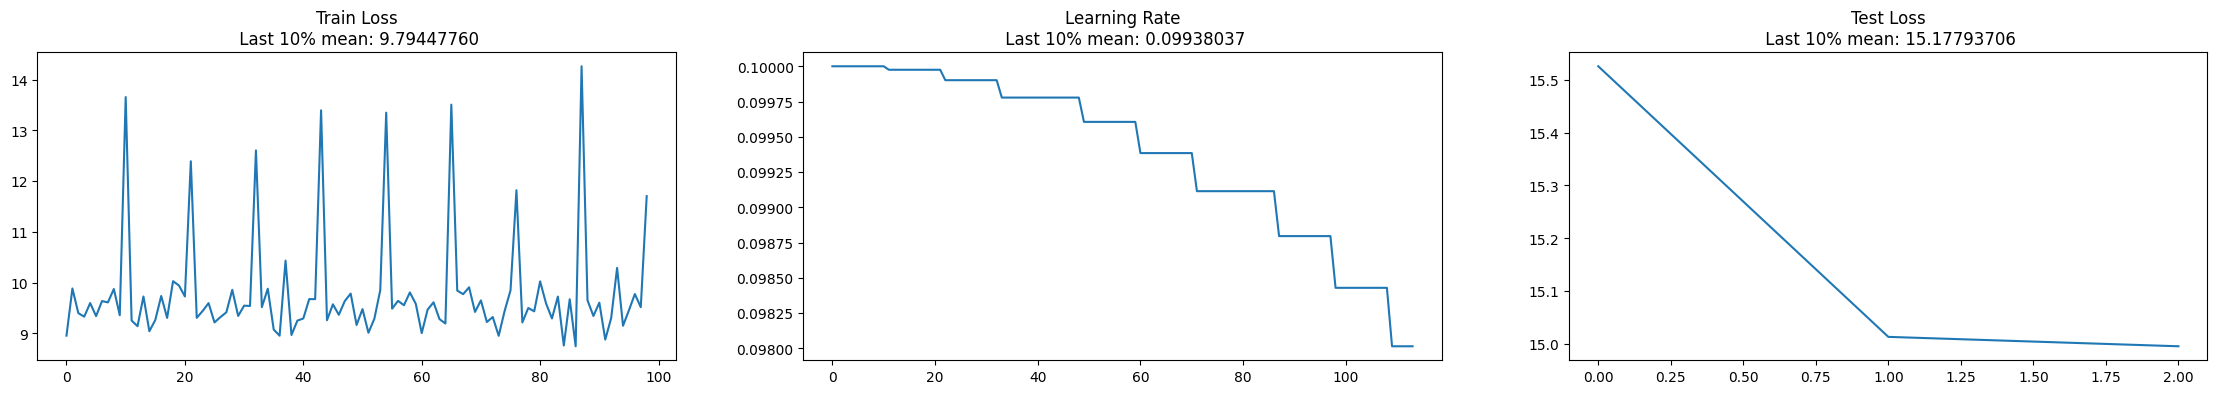

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pickle

# log_dir = f'{checkpoint_path}/logger'
log_dir = checkpoint_path + 'logger/'
# load the logger
with open(log_dir + '/logger_train_loss.pkl', 'rb') as f:
    logger_train_loss = pickle.load(f)
with open(log_dir + '/logger_lr.pkl', 'rb') as f:
    logger_lr = pickle.load(f)
with open(log_dir + '/logger_val_loss.pkl', 'rb') as f:
    logger_val_loss = pickle.load(f)
visualization_num = int(len(logger_val_loss)*0.1)

plt.figure(figsize=(28, 4))

plt.subplot(1,3,1)
plt.plot(logger_train_loss)
train_loss_last = np.mean(logger_train_loss[-visualization_num:])
plt.title('Train Loss\n Last 10% mean: {:.8f}'.format(train_loss_last))

plt.subplot(1,3,2)
plt.plot(logger_lr)
train_lr = np.mean(logger_lr[-visualization_num:])
plt.title('Learning Rate\n Last 10% mean: {:.8f}'.format(train_lr))

plt.subplot(1,3,3)
plt.plot(logger_val_loss)
test_loss_last = np.mean(logger_val_loss[-visualization_num:])
plt.title('Test Loss\n Last 10% mean: {:.8f}'.format(test_loss_last))



重构图

In [4]:
from Data.utils import transfer_date_to_id
from Data.Solardataloader import transfer_log1p

mag_feature_list = []
h_feature_list = []
start_date = transfer_date_to_id(2020, 6, 30)
end_date = transfer_date_to_id(2024, 6, 30)
print(start_date,end_date)

val_loader = Solardataloader_subset.get_loader_by_time(load_imgs=False,time_step=12*60,time_interval=[start_date,end_date] , enhance_list=[1024,0,0], batch_size=5, shuffle=False, num_workers=16)

with torch.no_grad():
    pretrainModel.eval()
    for i,data in enumerate(val_loader):
        if pretrain_args.modal == 'magnet':
            image = data[:,0,:,:,:]
        elif pretrain_args.modal == '0094':
            image = data[:,1,:,:,:]
        else:
            raise ValueError('modal error')
        image_recon = pretrainModel(image.to(device))

        break

vis_ids = np.arange(5)

image = image[vis_ids].cpu().numpy()
image_enhance = transfer_log1p(image)
image_recon = image_recon[vis_ids].cpu().numpy()    
image_recon_enhance = transfer_log1p(image_recon)

5346720 7450560
 magnet has 72889 samples
 0094 has 120206 samples
All modal has 1707 samples


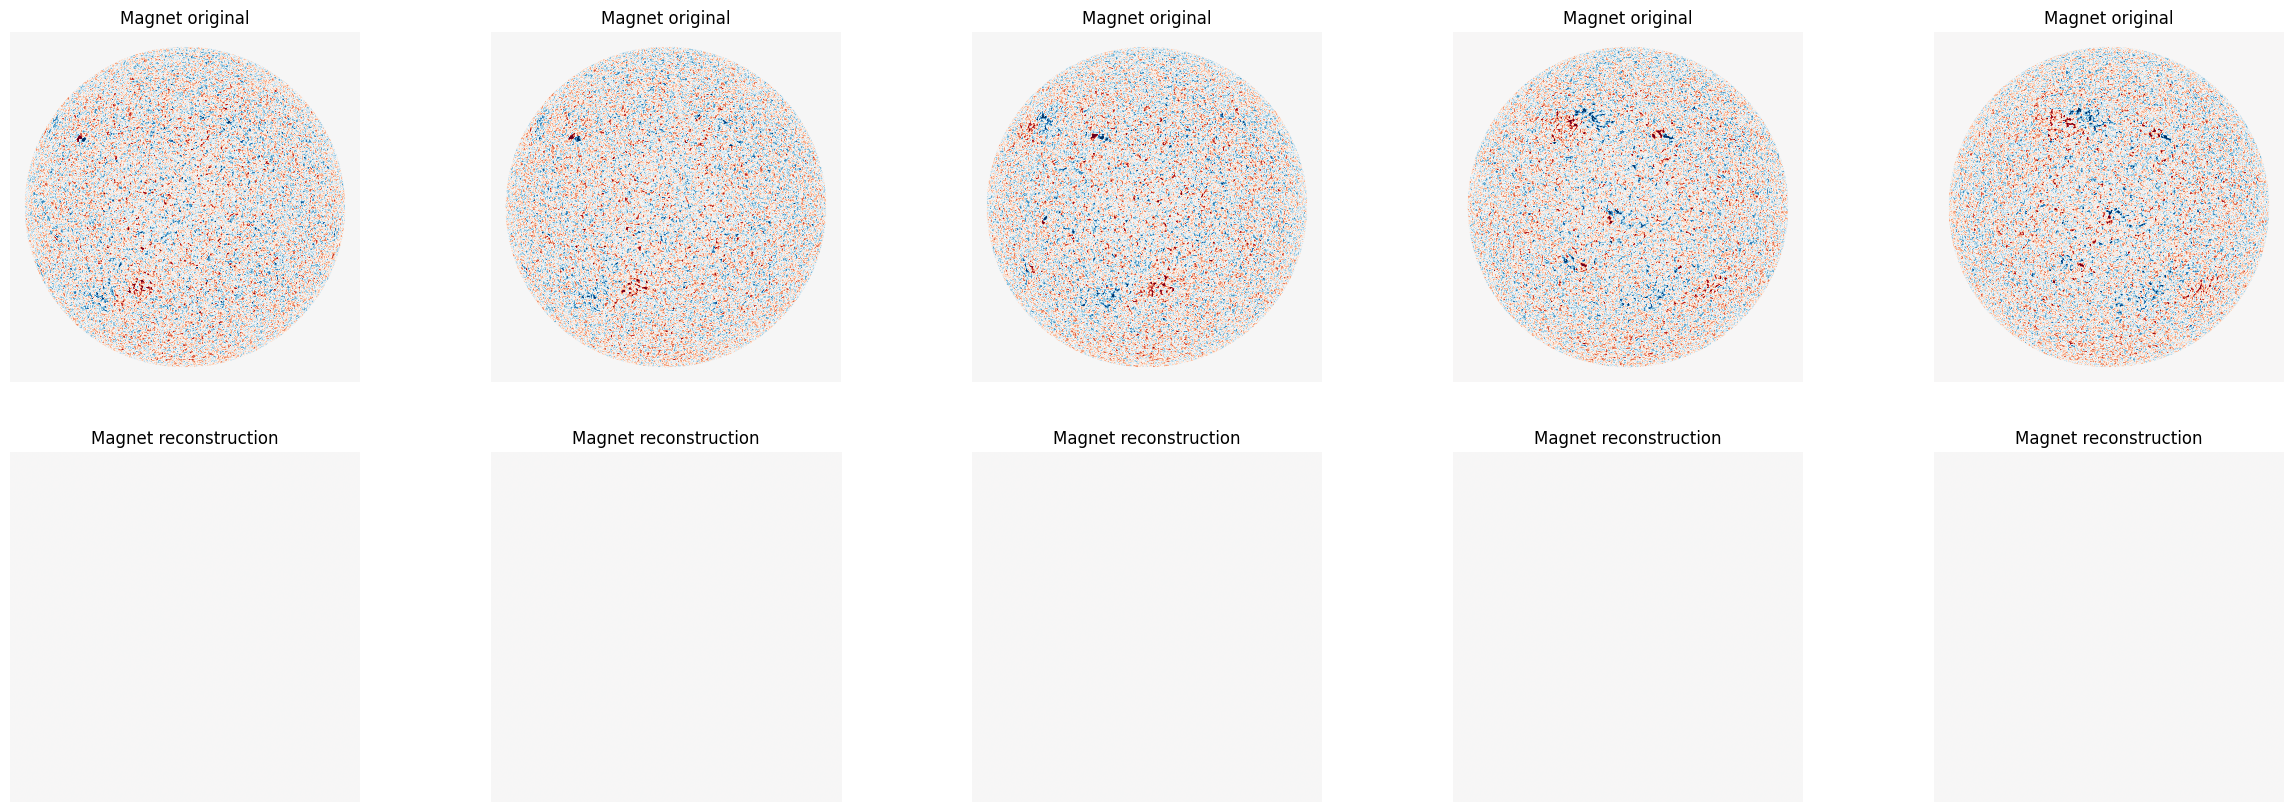

In [5]:
import matplotlib.pyplot as plt
import numpy as np
vis_ids = np.arange(5)

if pretrain_args.modal == 'magnet':
    vmin_magnet = np.min(image_enhance)
    vmax_magnet = np.max(image_enhance)
    vmax_magnet = np.max([np.abs(vmin_magnet), np.abs(vmax_magnet)])/2
    vmin_magnet = -vmax_magnet
elif pretrain_args.modal == '0094':
    vmin_0094 = np.min(image_enhance)
    vmax_0094 = np.max(image_enhance)
else:
    raise ValueError('modal error')

plt.figure(figsize=(30, 10))
for i in range(5):
    plt.subplot(2, 5, i+1)
    plt.imshow(image_enhance[i,0,:,:], cmap='RdBu_r',vmin=vmin_magnet, vmax=vmax_magnet)
    plt.axis('off')
    plt.title('Magnet original')
    plt.subplot(2, 5, i+6)
    plt.imshow(image_recon_enhance[i,0,:,:], cmap='RdBu_r',vmin=vmin_magnet, vmax=vmax_magnet)
    plt.axis('off')
    plt.title('Magnet reconstruction')
    # plt.subplot(2, 10, i+11)
    # plt.imshow(mag_recon[i,0,:,:], cmap='RdBu_r',vmin=vmin_magnet, vmax=vmax_magnet)
    # plt.axis('off')
    # plt.title('Magnet reconstruction')
    # plt.subplot(2, 10, i+16)
    # plt.imshow(h_recon[i,0,:,:], cmap='RdBu_r',vmin=vmin_magnet, vmax=vmax_magnet)
    # plt.axis('off')
    # plt.title('0094 reconstruction')


In [4]:
pretrain_json_path = './configs/pretrain/args3.json'

with open(pretrain_json_path, 'r') as f:
    pretrain_args = json.load(f)
    pretrain_args = SimpleNamespace(**pretrain_args)
for arg in vars(pretrain_args):
    print(arg, getattr(pretrain_args, arg))

checkpoint_path_mag = f'/mnt/nas/home/huxing/202407/ctf/SolarCLIP/checkpoints/pretrain_3/{pretrain_args.enhance_list[0]}/{pretrain_args.modal_list[0]}/'
logger_checkpoint_path_mag = checkpoint_path_mag + 'logger/'
model_checkpoint_path_mag = checkpoint_path_mag + 'model/'
load_dir_mag = model_checkpoint_path_mag + 'epoch_9.pt'

checkpoint_path_0094 = f'/mnt/nas/home/huxing/202407/ctf/SolarCLIP/checkpoints/pretrain_4/{pretrain_args.enhance_list[0]}/{pretrain_args.modal_list[1]}/'
logger_checkpoint_path_0094 = checkpoint_path_0094 + 'logger/'
model_checkpoint_path_0094 = checkpoint_path_0094 + 'model/'
load_dir_0094 = model_checkpoint_path_0094 + 'epoch_9.pt'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


encoder = Embeddings(
        in_channels=1,
        input_resolution=1024,
        patch_size=64,
        width=768,
        hidden_dropout_prob=1e-1
    )
decoder = LinearDecoder(image_size = 1024, patch_size = 64, embed_dim = 768)

pretrainModel_mag = PretrainModel(encoder, decoder).to(device)
pretrainModel_mag.load_state_dict(torch.load(load_dir_mag)['model'])
pretrainModel_mag.to(device)

pretrainModel_0094 = PretrainModel(encoder, decoder).to(device)
pretrainModel_0094.load_state_dict(torch.load(load_dir_0094)['model'])
pretrainModel_0094.to(device)

modal_list ['magnet', '0094']
enhance_list ['log1p', 1]
epochs 11
test_freq 3
save_freq 3


PretrainModel(
  (encoder): Embeddings(
    (conv1): Conv2d(1, 768, kernel_size=(64, 64), stride=(64, 64), bias=False)
    (ln_pre): patch_norm(
      (norm): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (decoder): LinearDecoder(
    (decoder): Sequential(
      (0): Linear(in_features=768, out_features=1536, bias=True)
      (1): SiLU()
      (2): Linear(in_features=1536, out_features=3072, bias=True)
      (3): SiLU()
      (4): Linear(in_features=3072, out_features=4096, bias=True)
    )
  )
)

训练曲线

In [5]:
print(pretrain_args.modal_list)

['magnet', '0094']


loading  magnet
loading  0094


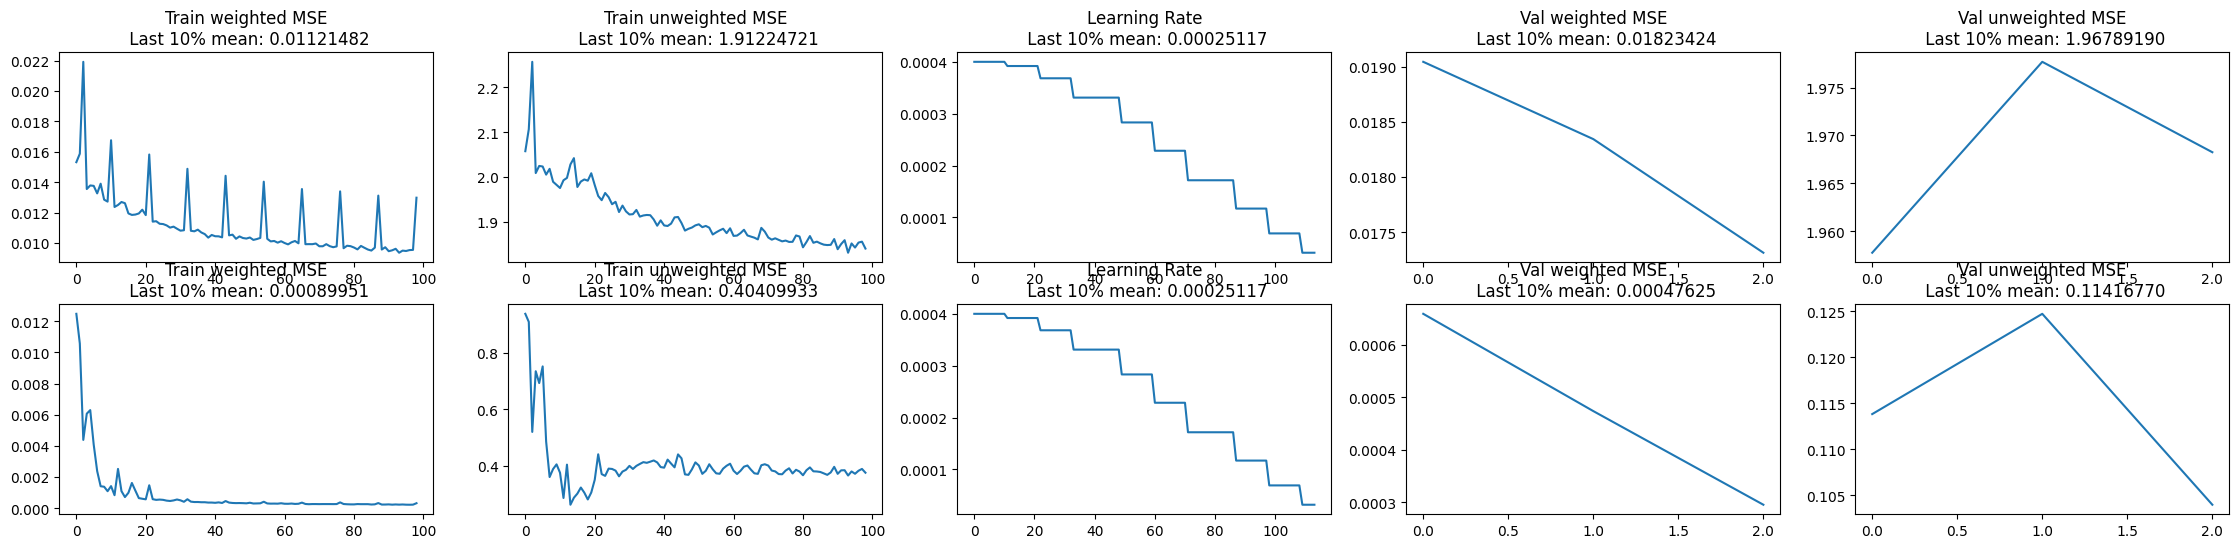

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pickle

logger_data = {}
# log_dir = f'{checkpoint_path}/logger'
log_dir_mag = checkpoint_path_mag + 'logger/'
log_dir_0094 = checkpoint_path_0094 + 'logger/'
checkpoint_path='/mnt/nas/home/huxing/202407/ctf/SolarCLIP/checkpoints/pretrain_4/log1p'
# load the logger
for modal in pretrain_args.modal_list:
    print('loading ',modal)
    log_dir = f"{checkpoint_path}/{modal}/logger"
    with open(log_dir + '/logger_train_loss.pkl', 'rb') as f:
        logger_data[f"logger_train_loss_{modal}"] = pickle.load(f)
    with open(log_dir + '/logger_train_loss_mse.pkl', 'rb') as f:
        logger_data[f"logger_train_loss_mse_{modal}"] = pickle.load(f)
    with open(log_dir + '/logger_lr.pkl', 'rb') as f:
        logger_data[f"logger_lr_{modal}"] = pickle.load(f)
    with open(log_dir + '/logger_val_loss.pkl', 'rb') as f:
        logger_data[f"logger_val_loss_{modal}"] = pickle.load(f)
    with open(log_dir + '/logger_val_loss_mse.pkl', 'rb') as f:
        logger_data[f"logger_val_loss_mse_{modal}"] = pickle.load(f)

visualization_num = int(len(logger_data['logger_val_loss_magnet'])*0.1)

plt.figure(figsize=(28, 6))
for i,modal in enumerate(pretrain_args.modal_list):
    plt.subplot(2,5,1+i*5)
    plt.plot(logger_data[f"logger_train_loss_{modal}"])
    train_loss_last = np.mean(logger_data[f"logger_train_loss_{modal}"][-visualization_num:])
    plt.title('Train weighted MSE\n Last 10% mean: {:.8f}'.format(train_loss_last))

    plt.subplot(2,5,2+i*5)
    plt.plot(logger_data[f"logger_train_loss_mse_{modal}"])
    train_loss_mse_last = np.mean(logger_data[f"logger_train_loss_mse_{modal}"][-visualization_num:])
    plt.title('Train unweighted MSE\n Last 10% mean: {:.8f}'.format(train_loss_mse_last))

    plt.subplot(2,5,3+i*5)
    plt.plot(logger_data[f"logger_lr_{modal}"])
    train_lr = np.mean(logger_data[f"logger_lr_{modal}"][-visualization_num:])
    plt.title('Learning Rate\n Last 10% mean: {:.8f}'.format(train_lr))

    plt.subplot(2,5,4+i*5)
    plt.plot(logger_data[f"logger_val_loss_{modal}"])
    val_loss_last = np.mean(logger_data[f"logger_val_loss_{modal}"][-visualization_num:])
    plt.title('Val weighted MSE\n Last 10% mean: {:.8f}'.format(val_loss_last))

    plt.subplot(2,5,5+i*5)
    plt.plot(logger_data[f"logger_val_loss_mse_{modal}"])
    val_loss_mse_last = np.mean(logger_data[f"logger_val_loss_mse_{modal}"][-visualization_num:])
    plt.title('Val unweighted MSE\n Last 10% mean: {:.8f}'.format(val_loss_mse_last))




In [8]:
from Data.utils import transfer_date_to_id
import torch
from Data.Solardataloader import transfer_log1p,enhance_funciton
from Data import Solardataloader_subset
from Model.get_weights_tq import get_weights

start_date = transfer_date_to_id(2020, 6, 30)
end_date = transfer_date_to_id(2024, 6, 30)
print(start_date,end_date)

val_loader = Solardataloader_subset.get_loader_by_time(load_imgs=False,time_step=12*60,time_interval=[start_date,end_date] , enhance_list=[1024,0,0], batch_size=5, num_workers=16)

with torch.no_grad():
    pretrainModel_mag.eval()
    pretrainModel_0094.eval()
    for i,data in enumerate(val_loader):
        image_mag = data[:,0,:,:,:]
        image_0094 = data[:,1,:,:,:]
        image_mag = enhance_funciton(image_mag, pretrain_args.enhance_list[0], pretrain_args.enhance_list[1])
        image_0094 = enhance_funciton(image_0094, pretrain_args.enhance_list[0], pretrain_args.enhance_list[1])
        weights_mag, _ = get_weights('cv-rdbu', image_mag)
        weights_0094, _ = get_weights('3sgm-continous', image_0094)
        image_mag_recon = pretrainModel_mag(image_mag.to(device))
        image_0094_recon = pretrainModel_0094(image_0094.to(device))

        break
vis_ids = np.arange(5)
image_mag = image_mag[vis_ids].cpu().numpy()
# image_mag_enhance = transfer_log1p(image_mag)
image_mag_recon = image_mag_recon[vis_ids].cpu().numpy()    
image_0094 = image_0094[vis_ids].cpu().numpy()
# image_0094_enhance = transfer_log1p(image_0094)
image_0094_recon = image_0094_recon[vis_ids].cpu().numpy()    
# image_0094_recon_enhance = transfer_log1p(image_0094_recon)

5346720 7450560
 magnet has 72889 samples
 0094 has 120206 samples
All modal has 1707 samples


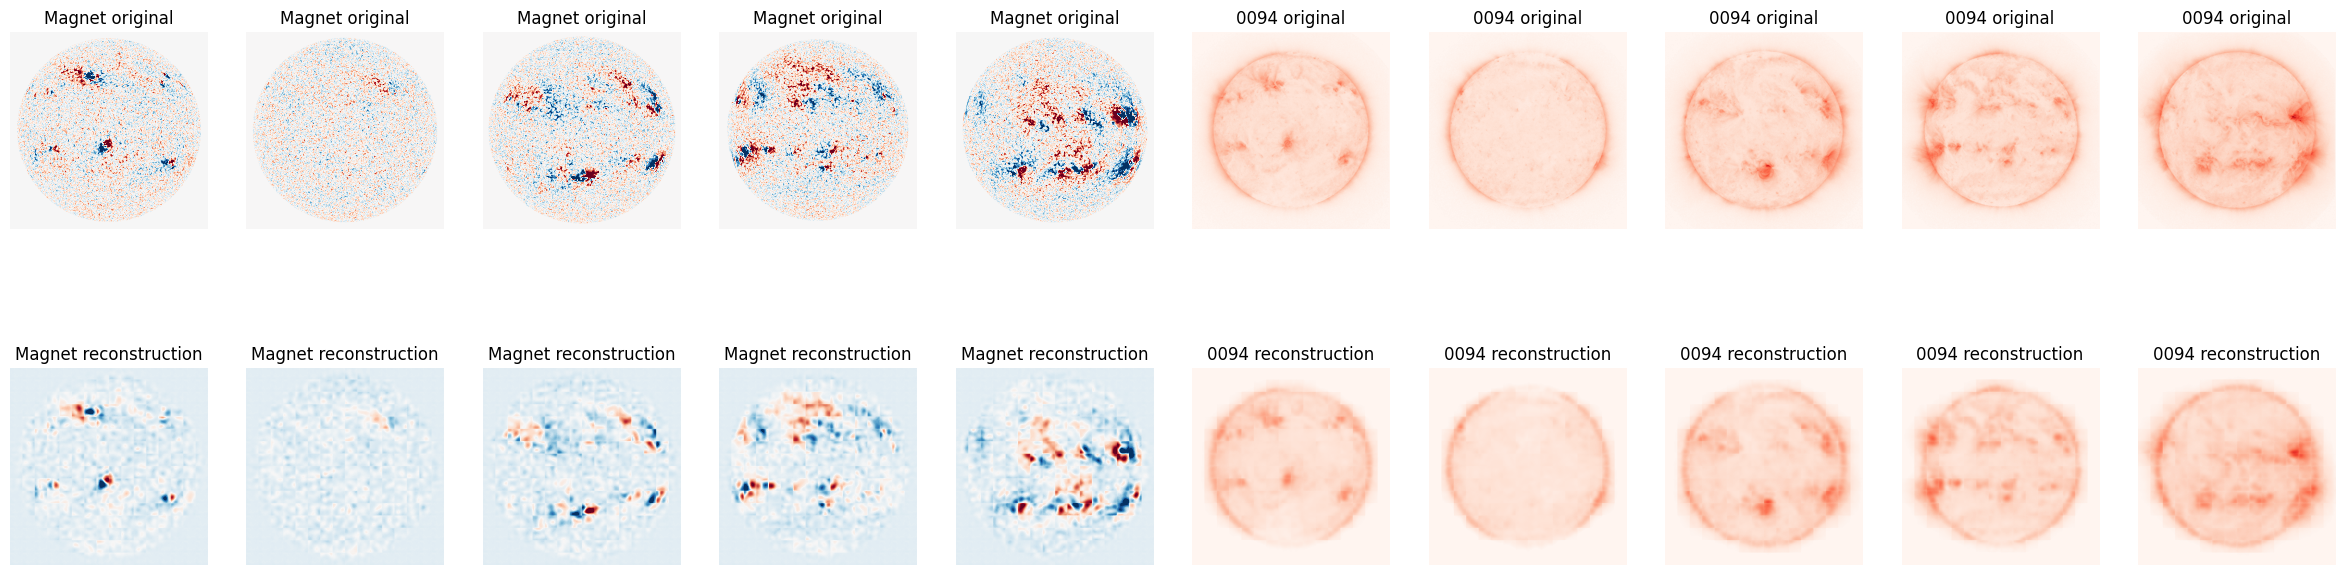

In [10]:
import matplotlib.pyplot as plt


vmin_magnet = np.min(image_mag)
vmax_magnet = np.max(image_mag)
vmax_magnet = np.max([np.abs(vmin_magnet), np.abs(vmax_magnet)])/2
vmin_magnet = -vmax_magnet
vmin_0094 = 0
vmax_0094 = np.max(image_0094)

plt.figure(figsize=(30, 8))
for i in range(5):
    plt.subplot(2, 10, i+1)
    plt.imshow(image_mag[i,0,:,:], cmap='RdBu_r',vmin=vmin_magnet, vmax=vmax_magnet)
    plt.axis('off')
    plt.title('Magnet original')
    plt.subplot(2, 10, i+6)
    plt.imshow(image_0094[i,0,:,:], cmap='Reds',vmin=vmin_0094, vmax=vmax_0094)
    plt.axis('off')
    plt.title('0094 original')
    plt.subplot(2, 10, i+11)
    plt.imshow(image_mag_recon[i,0,:,:], cmap='RdBu_r',vmin=vmin_magnet, vmax=vmax_magnet)
    plt.axis('off')
    plt.title('Magnet reconstruction')
    plt.subplot(2, 10, i+16)
    plt.imshow(image_0094_recon[i,0,:,:], cmap='Reds',vmin=vmin_0094, vmax=vmax_0094)
    plt.axis('off')
    plt.title('0094 reconstruction')
    


In [15]:
print(np.max(image_0094[0,0,:,:]))
print(np.max(image_0094[1,0,:,:]))
print(np.max(image_0094[2,0,:,:]))
print(np.max(image_0094[3,0,:,:]))
print(np.max(image_0094[4,0,:,:]))
print(np.max(image_0094_recon[0,0,:,:]))
print(np.max(image_0094_recon[1,0,:,:]))
print(np.max(image_0094_recon[2,0,:,:]))

7.0598326
4.5938563
5.085665
4.9667706
7.1857185
0.1564028
0.13214341
0.14268902


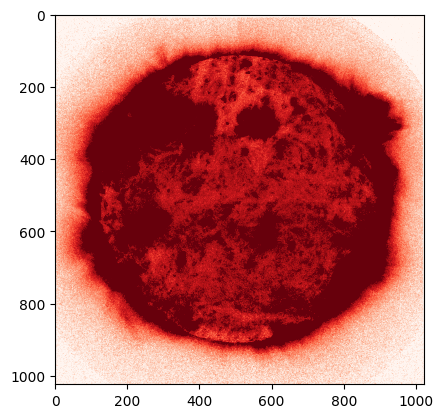

In [16]:
plt.imshow(image_0094[4,0,:,:], cmap='Reds',vmin=0, vmax=1.17)